In [1]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

!pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.2 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 49.5 MB/s eta 0:00:00
  P

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [3]:
%matplotlib inline
import os

os.environ["DGLBACKEND"] = "pytorch"     #specifies that DGL should use PyTorch as the backend for operations on graphs
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import dgl.function as fn                #contains a collection of built-in message-passing functions
import torch.nn.functional as F          #provides a set of functions that can be used to define the behavior of neural network layers (F.relu())
import shutil                            #provides a set of high-level operations on files and collections of files, such as copying, moving, and deleting files and directories.
from torch.utils.data import DataLoader
import cloudpickle                       #provides the ability to serialize and deserialize complex Python objects.
from dgl.nn import GraphConv
from sklearn.preprocessing import StandardScaler

In [4]:
current_dir = "/content/drive/MyDrive/Graph_regression/"

checkpoint_path = current_dir + "save_models/model_checkpoints/" + "checkpoint"
os.makedirs(checkpoint_path, exist_ok=True) #files for saving and resuming training,
                                            #evaluating model performance,
                                            # and making predictions on new data.

best_model_path = current_dir + "save_models/best_model/"

folder_data_temp = current_dir +"data_temp/" #store data that is only needed temporarily,
                                             #such as intermediate results or temporary copies of files.

shutil.rmtree(folder_data_temp, ignore_errors=True) #function can be used to delete a directory and
                                                    #its contents when it is no longer needed.

path_save = current_dir + "esol.zip"
shutil.unpack_archive(path_save, folder_data_temp) #This function automatically detects the archive
                                                   #format and extracts the contents to the specified directory.

In [5]:
!unzip /content/drive/MyDrive/Graph_regression/esol.zip

Archive:  /content/drive/MyDrive/Graph_regression/esol.zip
  inflating: scaffold_0_smiles_train.pickle  
  inflating: scaffold_0_test.bin     
  inflating: scaffold_0_val.bin      
  inflating: scaffold_0_smiles_val.pickle  
  inflating: scaffold_0_smiles_test.pickle  
  inflating: scaffold_0_train.bin    


In [7]:
train_graph = dgl.load_graphs('/content/drive/MyDrive/Graph_regression/data_temp/scaffold_0_train.bin')
train_graph

([Graph(num_nodes=6, num_edges=10,
        ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
        edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)}),
  Graph(num_nodes=2, num_edges=2,
        ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
        edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)}),
  Graph(num_nodes=1, num_edges=0,
        ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
        edata_schemes={'e': Scheme(shape=(20,), dtype=torch.float32)}),
  Graph(num_nodes=2, num_edges=2,
        ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
        edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)}),
  Graph(num_nodes=2, num_edges=2,
        ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
        edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)}),
  Graph(num_nodes=2, num_edges=2,
        ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
        e

In [8]:
type(train_graph)

tuple

In [9]:
train_graph[0][0]

Graph(num_nodes=6, num_edges=10,
      ndata_schemes={'v': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})

In [10]:
train_graph[1]['masks']

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [11]:
train_graph[1]['masks'].unique()#all of masks are 1 then we don't need mask in this project.

tensor([1.])

In [12]:
train_graph[1]['labels']

tensor([[-2.0600],
        [-2.6800],
        [-7.9600],
        [-1.4100],
        [-0.4700],
        [-2.9400],
        [-4.1100],
        [-1.8100],
        [-3.1700],
        [-4.7550],
        [-1.6400],
        [-0.8500],
        [-4.8100],
        [-0.1500],
        [-0.6300],
        [-1.5500],
        [-3.6600],
        [-5.0500],
        [-0.1900],
        [-0.8200],
        [-2.6800],
        [-2.2500],
        [-1.9200],
        [-1.7300],
        [-1.9950],
        [ 0.3200],
        [-3.6700],
        [-0.8000],
        [-1.3400],
        [-0.6300],
        [ 0.5800],
        [-2.5500],
        [-3.1800],
        [-3.0300],
        [-4.8000],
        [-5.5100],
        [-0.6000],
        [-4.4300],
        [-0.8200],
        [-2.5400],
        [-1.9600],
        [ 1.5700],
        [ 0.5200],
        [-1.2400],
        [-2.7300],
        [-1.8700],
        [-0.7200],
        [-0.0200],
        [-1.3000],
        [-2.4600],
        [-0.2200],
        [-1.8070],
        [-1.

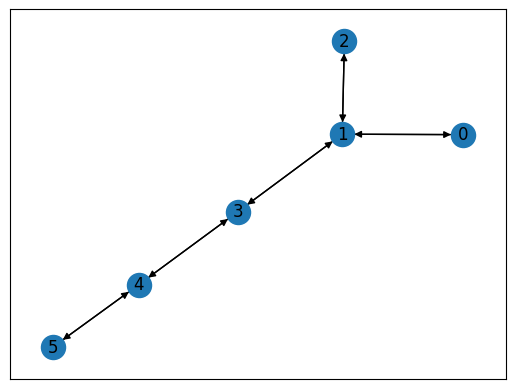

In [14]:
nx.draw_networkx(train_graph[0][0].to_networkx(), with_labels = True) #one of the graph in training set.

Regression Dataset

In [6]:
class DGLDatasetReg(torch.utils.data.Dataset):
    def __init__(self, address, transform=None, train=False, scaler=None):
            self.transform = transform
            self.train = train
            self.scaler = scaler
            self.list_graphs, train_labels_globals = dgl.load_graphs(address+"bin") # load graphs and extract the labels, and globals for the graphs.
            num_graphs = len(self.list_graphs) #number of graphs in the datase
            self.labels = train_labels_globals["labels"].view(num_graphs,-1)
            self.globals = train_labels_globals["globals"].view(num_graphs,-1)



    #scaler_method is used to ensure that the labels are normalized during training and testing.
    #If self.train is True, it fits the scaler to the labels and returns it otherwise, it just
    #returns the scaler that was fitted during training
    def scaler_method(self):
        if self.train:
            scaler = StandardScaler().fit(self.labels)
            self.scaler = scaler
        return self.scaler

    def __len__(self):
        return len(self.list_graphs)

    def __getitem__(self, idx):
        return  self.list_graphs[idx], torch.tensor(self.scaler.transform(self.labels)[idx]).float(), self.globals[idx] #This tuple represents a single example from the dataset.

Train_Validation_Test Set

In [15]:
path_data_temp = folder_data_temp + "scaffold"+"_"+str(0)
train_set = DGLDatasetReg(address=path_data_temp+"_train.", train=True)
scaler = train_set.scaler_method()
val_set = DGLDatasetReg(address=path_data_temp+"_val.", scaler=scaler)
test_set = DGLDatasetReg(address=path_data_temp+"_test.", scaler=scaler)
print('Size of train set : {}, Size of validation set : {}, Size of test set : {}'.format(len(train_set), len(val_set), len(test_set)))

Size of train set : 902, Size of validation set : 112, Size of test set : 114


Dataloader

In [16]:
#The collate_fn argument specifies the function that should be used to collate the data from each batch into a single batch
def collate(batch):
    # batch is a list of tuples (graphs, labels, globals)
    # Concatenate a sequence of graphs
    graphs = [e[0] for e in batch]
    g = dgl.batch(graphs)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[1] for e in batch]
    labels = torch.stack(labels, 0) #stacked along the first (horizontal) dimension.

    # Concatenate a sequence of tensors (globals) along a new dimension
    globals = [e[2] for e in batch]
    globals = torch.stack(globals, 0)

    return g, labels, globals


def loader(batch_size=64):
    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,  #the last batch will be included even if it is smaller than the specified batch size.
                              shuffle=True,
                              num_workers=1)    #specifies the number of worker processes that should be used to load the data in parallel.


    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False,
                             num_workers=1)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False,
                             num_workers=1)
    return train_dataloader, val_dataloader, test_dataloader

In [17]:
train_dataloader, val_dataloader, test_dataloader = loader(batch_size=64)

Some variables

In [18]:
num_tasks = 1     #Esol dataset has 1 task.
global_size = 200 # Size of global feature of each graph
num_epochs = 100  # Number of epochs to train the model
patience = 10     # Number of steps to wait if the model performance on the validation set does not improve

#Configurations to instantiate the model
config = {"node_feature_size":127, "edge_feature_size":12, "hidden_size":100}


Defining GNN

In [19]:
# MODEL(1) :two GraphConv layers
class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127) #returns the value associated with the key in the dictionary. If the key is not found in the dictionary, the method returns the default value 127.

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = GraphConv(self.node_feature_size, self.hidden_size, allow_zero_in_degree='True')  #The allow_zero_in_degree parameter is set to True to allow nodes with zero incoming edges.
        self.conv2 = GraphConv(self.hidden_size, self.num_tasks, allow_zero_in_degree='True')

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size] #represents the node features and is sliced to the size of self.node_feature_size
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size] #represents the edge features and is sliced to the size of self.edge_feature_size.
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h

        return dgl.mean_nodes(mol_dgl_graph, "h") #The node-level representation is then aggregated to a single graph-level representation

Compute score of the model ---> RMSE

In [20]:
def compute_score(model, data_loader, val_size, num_tasks):
    model.eval() #switch for some specific parts of the model that behave differently during training and evaluating time
    loss_sum = nn.MSELoss(reduction='sum') # MSE with sum instead of mean, i.e., sum_i[(y_i)^2-(y'_i)^2]
    final_loss = 0
    with torch.no_grad(): #turn off gradients computation
        for i, (mol_dgl_graph, labels, globals) in enumerate(data_loader): #iterates over each batch of the DataLoader and computes the model's predictions for the batch.
            prediction = model(mol_dgl_graph, globals)
            prediction = torch.tensor(scaler.inverse_transform(prediction.detach().cpu())) #The predictions are transformed back to the original scale
            labels = torch.tensor(scaler.inverse_transform(labels.cpu())) #The labels are then transformed back to the original scale
                                                                          #when evaluating the model on new data, it is important to transform
                                                                          #the model's outputs back to their original scale to obtain meaningful
                                                                          #predictions that can be compared to the true values.

            loss = loss_sum(prediction, labels)
            final_loss += loss.item()
        final_loss /= val_size
        final_loss = np.sqrt(final_loss)  # RMSE
    return final_loss / num_tasks

Defining loss function

In [21]:
def loss_func(output, label, num_tasks):
    criterion = nn.MSELoss()
    loss = criterion(output,label)
    loss = loss.sum()
    return loss

training

In [22]:
def train_epoch(train_dataloader, model, optimizer):
    epoch_train_loss = 0
    iterations = 0
    model.train() # Prepare model for training
    for i, (mol_dgl_graph, labels, globals) in enumerate(train_dataloader):
        prediction = model(mol_dgl_graph, globals)
        loss_train = loss_func(prediction, labels, num_tasks)
        optimizer.zero_grad(set_to_none=True) #clear any previous gradients that might still be stored in the optimizer.
        loss_train.backward()  #update the model's parameters based
        optimizer.step()
        epoch_train_loss += loss_train.detach().item()
        iterations += 1
    epoch_train_loss /= iterations
    return epoch_train_loss

In [23]:
def train_evaluate():  #The function saves the best model checkpoint based on the validation score and returns the average validation
                       #score over the best checkpoints.

    model = GNN(config, global_size, num_tasks)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

    best_val = np.Inf
    patience_count = 1
    epoch = 1

    while epoch <= num_epochs:
        if patience_count <= patience: #checks whether the patience count has exceeded the specified patience patience. If not:
            model.train() #it trains the model for one epoch using the train_epoch function
            loss_train = train_epoch(train_dataloader, model, optimizer)
            model.eval()
            score_val = compute_score(model, val_dataloader, len(val_set), num_tasks) #computes the validation score using the compute_score function.
            if score_val < best_val:#If the current best validation score is better than the validation score, the function saves the model checkpoint
                                     #to a file using cloudpickle, updates the best_val variable, and resets the patience_count to 1. Otherwise,
                                     #it increments the patience_count by 1
                best_val = score_val
                print("Save checkpoint")
                path = os.path.join(checkpoint_path, 'checkpoint.pth')
                dict_checkpoint = {"score_val": score_val}
                dict_checkpoint.update({"model_state_dict": model.state_dict(), "optimizer_state": optimizer.state_dict()})
                with open(path, "wb") as outputfile: #open function is called to open the file specified by the path variable in binary write mode ("wb").
                                                     #Binary write mode ("wb") is a file mode in Python that is used to open a file for writing binary data.
                                                     #In binary mode, the data is written to the file as a sequence of bytes, rather than as text characters.
                    cloudpickle.dump(dict_checkpoint, outputfile) #serialize the dict_checkpoint dictionary and write the resulting bytes to the open file.
                patience_count = 1
            else:
                print("Patience", patience_count)
                patience_count += 1

            print("Epoch: {}/{} | Training Loss: {:.3f} | Valid Score: {:.3f}".format(
            epoch, num_epochs, loss_train, score_val))

            print(" ")
            print("Epoch: {}/{} | Best Valid Score Until Now: {:.3f}".format(epoch, num_epochs, best_val), "\n")
        epoch += 1

    # best model save
    # Once the loop finishes, the function saves the best model checkpoint to a directory named best_model_path and prints the final average validation score
    # based on the best checkpoints.
    shutil.rmtree(best_model_path, ignore_errors=True) #remove the best_model_path directory and its contents if it already exists.
                                                       #The ignore_errors=True argument is provided to ignore any errors that might occur if the directory does not exist.
    shutil.copytree(checkpoint_path, best_model_path)

    print("Final results:")
    print("Average Valid Score: {:.3f}".format(np.mean(best_val)), "\n")


In [24]:
#evaluates the final GNN model on a test set and prints the test score.
def test_evaluate():
    final_model = GNN(config, global_size, num_tasks)
    path = os.path.join(best_model_path, 'checkpoint.pth') #loads the best model checkpoint from the best_model_path directory using cloudpickle.load,
                                                            #which reads the serialized dictionary from the file and returns it as a Python object.
    with open(path, 'rb') as f:
        checkpoint = cloudpickle.load(f)
    final_model.load_state_dict(checkpoint["model_state_dict"])
    final_model.eval()
    test_score = compute_score(final_model, test_dataloader, len(test_set), num_tasks)#The function then computes the test score using the compute_score function on the test DataLoader


    print("Test Score: {:.3f}".format(test_score), "\n")
    print("Execution time: {:.3f} seconds".format(time.time() - start_time))


In [ ]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 0.987 | Valid Score: 2.290
 
Epoch: 1/100 | Best Valid Score Until Now: 2.290 

Save checkpoint
Epoch: 2/100 | Training Loss: 0.963 | Valid Score: 2.251
 
Epoch: 2/100 | Best Valid Score Until Now: 2.251 

Save checkpoint
Epoch: 3/100 | Training Loss: 0.951 | Valid Score: 2.224
 
Epoch: 3/100 | Best Valid Score Until Now: 2.224 

Save checkpoint
Epoch: 4/100 | Training Loss: 0.972 | Valid Score: 2.220
 
Epoch: 4/100 | Best Valid Score Until Now: 2.220 

Save checkpoint
Epoch: 5/100 | Training Loss: 0.995 | Valid Score: 2.208
 
Epoch: 5/100 | Best Valid Score Until Now: 2.208 

Patience 1
Epoch: 6/100 | Training Loss: 0.965 | Valid Score: 2.216
 
Epoch: 6/100 | Best Valid Score Until Now: 2.208 

Patience 2
Epoch: 7/100 | Training Loss: 1.005 | Valid Score: 2.218
 
Epoch: 7/100 | Best Valid Score Until Now: 2.208 

Patience 3
Epoch: 8/100 | Training Loss: 0.923 | Valid Score: 2.215
 
Epoch: 8/100 | Best Valid Score Until Now: 2.208 

Patienc

In [ ]:
class Desired_GNN_1(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Desired_GNN_1, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g, h):

        with g.local_scope():
            g.ndata["h"] = h
            # update_all is a message passing API.
            g.update_all(
                message_func=fn.u_add_v('h', 'h', 'm'),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

In [ ]:
#MODEL(2)

class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = Desired_GNN_1(self.node_feature_size, self.hidden_size )
        self.conv2 = Desired_GNN_1(self.hidden_size, self.num_tasks )

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [ ]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 1.038 | Valid Score: 2.150
 
Epoch: 1/100 | Best Valid Score Until Now: 2.150 

Patience 1
Epoch: 2/100 | Training Loss: 0.959 | Valid Score: 2.172
 
Epoch: 2/100 | Best Valid Score Until Now: 2.150 

Patience 2
Epoch: 3/100 | Training Loss: 0.917 | Valid Score: 2.161
 
Epoch: 3/100 | Best Valid Score Until Now: 2.150 

Save checkpoint
Epoch: 4/100 | Training Loss: 0.924 | Valid Score: 2.140
 
Epoch: 4/100 | Best Valid Score Until Now: 2.140 

Save checkpoint
Epoch: 5/100 | Training Loss: 0.995 | Valid Score: 2.126
 
Epoch: 5/100 | Best Valid Score Until Now: 2.126 

Patience 1
Epoch: 6/100 | Training Loss: 0.968 | Valid Score: 2.134
 
Epoch: 6/100 | Best Valid Score Until Now: 2.126 

Patience 2
Epoch: 7/100 | Training Loss: 0.924 | Valid Score: 2.141
 
Epoch: 7/100 | Best Valid Score Until Now: 2.126 

Patience 3
Epoch: 8/100 | Training Loss: 0.884 | Valid Score: 2.154
 
Epoch: 8/100 | Best Valid Score Until Now: 2.126 

Save checkpoint
E

In [ ]:
class Desired_GNN_2(nn.Module):

    def __init__(self, in_feat, out_feat):
        super(Desired_GNN_2, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g, h):

        with g.local_scope():
            g.ndata["h"] = h
            # update_all is a message passing API.
            g.update_all(
                message_func=fn.u_mul_v('h', 'h', 'm'),
                reduce_func=fn.sum("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

In [ ]:
#MODEL(3)

class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = Desired_GNN_2(self.node_feature_size, self.hidden_size )
        self.conv2 = Desired_GNN_2(self.hidden_size, self.num_tasks )

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [ ]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 1.185 | Valid Score: 2.333
 
Epoch: 1/100 | Best Valid Score Until Now: 2.333 

Save checkpoint
Epoch: 2/100 | Training Loss: 1.114 | Valid Score: 2.253
 
Epoch: 2/100 | Best Valid Score Until Now: 2.253 

Save checkpoint
Epoch: 3/100 | Training Loss: 1.016 | Valid Score: 2.190
 
Epoch: 3/100 | Best Valid Score Until Now: 2.190 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.002 | Valid Score: 2.145
 
Epoch: 4/100 | Best Valid Score Until Now: 2.145 

Save checkpoint
Epoch: 5/100 | Training Loss: 0.975 | Valid Score: 2.123
 
Epoch: 5/100 | Best Valid Score Until Now: 2.123 

Save checkpoint
Epoch: 6/100 | Training Loss: 1.061 | Valid Score: 2.110
 
Epoch: 6/100 | Best Valid Score Until Now: 2.110 

Save checkpoint
Epoch: 7/100 | Training Loss: 0.939 | Valid Score: 2.105
 
Epoch: 7/100 | Best Valid Score Until Now: 2.105 

Save checkpoint
Epoch: 8/100 | Training Loss: 0.908 | Valid Score: 2.104
 
Epoch: 8/100 | Best Valid Score Until Now: 

In [ ]:
#MODEL(4)

class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = Desired_GNN_2(self.node_feature_size, self.hidden_size )
        self.conv2 = Desired_GNN_2(self.hidden_size, self.hidden_size )
        self.conv3 = Desired_GNN_2(self.hidden_size, self.hidden_size )
        self.conv4 = Desired_GNN_2(self.hidden_size, self.num_tasks )

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.conv3(mol_dgl_graph, h)
        h = F.relu(h)
        h = self.conv4(mol_dgl_graph, h)

        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [ ]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 1.081 | Valid Score: 2.186
 
Epoch: 1/100 | Best Valid Score Until Now: 2.186 

Save checkpoint
Epoch: 2/100 | Training Loss: 1.063 | Valid Score: 2.182
 
Epoch: 2/100 | Best Valid Score Until Now: 2.182 

Save checkpoint
Epoch: 3/100 | Training Loss: 0.963 | Valid Score: 2.178
 
Epoch: 3/100 | Best Valid Score Until Now: 2.178 

Save checkpoint
Epoch: 4/100 | Training Loss: 1.056 | Valid Score: 2.175
 
Epoch: 4/100 | Best Valid Score Until Now: 2.175 

Save checkpoint
Epoch: 5/100 | Training Loss: 0.999 | Valid Score: 2.168
 
Epoch: 5/100 | Best Valid Score Until Now: 2.168 

Save checkpoint
Epoch: 6/100 | Training Loss: 0.956 | Valid Score: 2.159
 
Epoch: 6/100 | Best Valid Score Until Now: 2.159 

Save checkpoint
Epoch: 7/100 | Training Loss: 0.967 | Valid Score: 2.154
 
Epoch: 7/100 | Best Valid Score Until Now: 2.154 

Save checkpoint
Epoch: 8/100 | Training Loss: 0.975 | Valid Score: 2.152
 
Epoch: 8/100 | Best Valid Score Until Now: 

In [ ]:
#MODEL(5)

class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = Desired_GNN_2(self.node_feature_size, self.hidden_size )
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.conv2 = Desired_GNN_2(self.hidden_size, self.hidden_size )
        self.bn2 = nn.BatchNorm1d(self.hidden_size)
        self.conv3 = Desired_GNN_2(self.hidden_size, self.hidden_size )
        self.bn3 = nn.BatchNorm1d(self.hidden_size)
        self.conv4 = Desired_GNN_2(self.hidden_size, self.num_tasks )

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = self.bn1(h)
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.conv3(mol_dgl_graph, h)
        h = self.bn3(h)
        h = F.relu(h)
        h = self.conv4(mol_dgl_graph, h)

        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [ ]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 2.527 | Valid Score: 2.179
 
Epoch: 1/100 | Best Valid Score Until Now: 2.179 

Patience 1
Epoch: 2/100 | Training Loss: 1.715 | Valid Score: 2.347
 
Epoch: 2/100 | Best Valid Score Until Now: 2.179 

Patience 2
Epoch: 3/100 | Training Loss: 1.479 | Valid Score: 2.589
 
Epoch: 3/100 | Best Valid Score Until Now: 2.179 

Patience 3
Epoch: 4/100 | Training Loss: 1.339 | Valid Score: 6.919
 
Epoch: 4/100 | Best Valid Score Until Now: 2.179 

Patience 4
Epoch: 5/100 | Training Loss: 1.272 | Valid Score: 7.368
 
Epoch: 5/100 | Best Valid Score Until Now: 2.179 

Patience 5
Epoch: 6/100 | Training Loss: 1.356 | Valid Score: 4.321
 
Epoch: 6/100 | Best Valid Score Until Now: 2.179 

Patience 6
Epoch: 7/100 | Training Loss: 1.134 | Valid Score: 4.379
 
Epoch: 7/100 | Best Valid Score Until Now: 2.179 

Patience 7
Epoch: 8/100 | Training Loss: 1.153 | Valid Score: 5.138
 
Epoch: 8/100 | Best Valid Score Until Now: 2.179 

Patience 8
Epoch: 9/100 | T

In [ ]:
#MODEL(6)

class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = Desired_GNN_2(self.node_feature_size, self.hidden_size )
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.d1 = nn.Dropout(0.5)
        self.conv2 = Desired_GNN_2(self.hidden_size, self.hidden_size )
        self.bn2 = nn.BatchNorm1d(self.hidden_size)
        self.conv3 = Desired_GNN_2(self.hidden_size, self.hidden_size )
        self.bn3 = nn.BatchNorm1d(self.hidden_size)
        self.d2 = nn.Dropout(0.5)
        self.conv4 = Desired_GNN_2(self.hidden_size, self.num_tasks )

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"])
        h = self.bn1(h)
        h = F.relu(h)
        h = self.d1(h)
        h = self.conv2(mol_dgl_graph, h)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.conv3(mol_dgl_graph, h)
        h = self.bn3(h)
        h = F.relu(h)
        h = self.d2(h)
        h = self.conv4(mol_dgl_graph, h)

        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [ ]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 8.276 | Valid Score: 2.130
 
Epoch: 1/100 | Best Valid Score Until Now: 2.130 

Patience 1
Epoch: 2/100 | Training Loss: 11.308 | Valid Score: 2.133
 
Epoch: 2/100 | Best Valid Score Until Now: 2.130 

Patience 2
Epoch: 3/100 | Training Loss: 5.837 | Valid Score: 2.162
 
Epoch: 3/100 | Best Valid Score Until Now: 2.130 

Patience 3
Epoch: 4/100 | Training Loss: 5.720 | Valid Score: 2.188
 
Epoch: 4/100 | Best Valid Score Until Now: 2.130 

Patience 4
Epoch: 5/100 | Training Loss: 6.249 | Valid Score: 2.319
 
Epoch: 5/100 | Best Valid Score Until Now: 2.130 

Patience 5
Epoch: 6/100 | Training Loss: 6.985 | Valid Score: 2.777
 
Epoch: 6/100 | Best Valid Score Until Now: 2.130 

Patience 6
Epoch: 7/100 | Training Loss: 6.824 | Valid Score: 3.292
 
Epoch: 7/100 | Best Valid Score Until Now: 2.130 

Patience 7
Epoch: 8/100 | Training Loss: 5.827 | Valid Score: 2.678
 
Epoch: 8/100 | Best Valid Score Until Now: 2.130 

Patience 8
Epoch: 9/100 | 

In [25]:
class Desired_GNN_3(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Desired_GNN_3, self).__init__()
        self.linear = nn.Linear(in_feat + 12 , out_feat) #12 is number of edge feature

    def forward(self, g, h, w):
        with g.local_scope():
            g.ndata["h"] = h
            g.edata["w"] = w
            g.update_all(
                message_func=fn.copy_e("w", "m"),
                reduce_func=fn.sum("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            # print(h_total.shape)
            return self.linear(h_total)


In [26]:
#MODEL(7)

class GNN(nn.Module):
    def __init__(self, config, global_size = 200, num_tasks = 1):
        super().__init__()
        self.config = config
        self.num_tasks = num_tasks

        # Node feature size
        self.node_feature_size = self.config.get('node_feature_size', 127)

        # Edge feature size
        self.edge_feature_size = self.config.get('edge_feature_size', 12)

        # Hidden size
        self.hidden_size = self.config.get('hidden_size', 100)

        self.conv1 = Desired_GNN_3(self.node_feature_size, self.hidden_size )
        self.conv2 = Desired_GNN_3(self.hidden_size, self.num_tasks )

    # def forward(self, g, in_feat):
    def forward(self, mol_dgl_graph, globals):
        mol_dgl_graph.ndata["v"]= mol_dgl_graph.ndata["v"][:,:self.node_feature_size]
        mol_dgl_graph.edata["e"] = mol_dgl_graph.edata["e"][:,:self.edge_feature_size]
        h = self.conv1(mol_dgl_graph, mol_dgl_graph.ndata["v"], mol_dgl_graph.edata["e"])
        h = F.relu(h)
        h = self.conv2(mol_dgl_graph, h, mol_dgl_graph.edata["e"])
        mol_dgl_graph.ndata["h"] = h
        return dgl.mean_nodes(mol_dgl_graph, "h")

In [27]:
import time
start_time = time.time()

train_evaluate()
test_evaluate()

Save checkpoint
Epoch: 1/100 | Training Loss: 0.999 | Valid Score: 2.174
 
Epoch: 1/100 | Best Valid Score Until Now: 2.174 

Patience 1
Epoch: 2/100 | Training Loss: 1.012 | Valid Score: 2.181
 
Epoch: 2/100 | Best Valid Score Until Now: 2.174 

Patience 2
Epoch: 3/100 | Training Loss: 0.980 | Valid Score: 2.189
 
Epoch: 3/100 | Best Valid Score Until Now: 2.174 

Patience 3
Epoch: 4/100 | Training Loss: 0.970 | Valid Score: 2.180
 
Epoch: 4/100 | Best Valid Score Until Now: 2.174 

Patience 4
Epoch: 5/100 | Training Loss: 1.030 | Valid Score: 2.179
 
Epoch: 5/100 | Best Valid Score Until Now: 2.174 

Patience 5
Epoch: 6/100 | Training Loss: 1.019 | Valid Score: 2.175
 
Epoch: 6/100 | Best Valid Score Until Now: 2.174 

Save checkpoint
Epoch: 7/100 | Training Loss: 0.978 | Valid Score: 2.165
 
Epoch: 7/100 | Best Valid Score Until Now: 2.165 

Save checkpoint
Epoch: 8/100 | Training Loss: 0.969 | Valid Score: 2.161
 
Epoch: 8/100 | Best Valid Score Until Now: 2.161 

Patience 1
Epoch: